In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [62]:
data_folder = "../data"
surrogate_data_folder = os.path.join(data_folder, "surrogate", "data")
log_folder = os.path.join(data_folder, "logs")

output_images_folder = 'images'
if not os.path.exists(output_images_folder):
    os.makedirs(output_images_folder)

## What to display ?

- **1. Curve of performance runs during search process (`surrogate/data`) :**
    - best solution score (in means from 5 runs)
    - comparisons of different orders
    - comparisons of different LS iterations per orders
    - extract times of computation (`data/logs`)
    - surrogate model performance during training (r²)


- **2. From only best last solutions found displays :**
    - bar plot of best attribute selected for classification per order
    - same for the two orders 

### 1. Curve of performances runs during search process (`surrogate/data`)

In [44]:
# fixed parameters
ILS = 1000
POP = 20
N_RUNS = 5
SS = 50 # start surrogate training after at least 50 real evaluations
SE = 10 # train every 10 real evaluations

In [71]:
def extract_params(filename):
    #pop_size = filename.split('-')[2].replace('POP_', '')
    ls_iter = filename.split('-')[3].replace('LS_', '')
    s_order = filename.split('-')[5].replace('SO_', '')

    return int(ls_iter), int(s_order)

In [82]:
files = os.listdir(surrogate_data_folder)

data_results = {}
for i in range(1, N_RUNS + 1):
    for run in [ f for f in files if f"RUN_{i}_performance" in f ]:
        
        key = extract_params(run)
        if key not in data_results:
            data_results[key] = []

        # need to extract the 50 first solution found from surrogate data file
        data_file = os.path.join(surrogate_data_folder, run.replace('_performance.csv', ''))

        scores = []
        with open(data_file, 'r') as f:
            lines = f.readlines()

            for line in lines[1:SS + 1]:
                scores.append(float(line.split(';')[-1]))
        
        with open(os.path.join(surrogate_data_folder, run), 'r') as f:
            lines = f.readlines()

            for index, line in enumerate(lines[:ILS - SS]):
                #print(f'{index} => {run}')
                #print(line)
                scores.append(float(line.split(';')[-2]))

        # append run data into dictionnary with its key
        data_results[key].append(scores)

In [83]:
for k in sorted(data_results.keys()):
    print(f'{k} has {len(data_results[k])} runs')

(100, 1) has 5 runs
(100, 2) has 5 runs
(500, 1) has 5 runs
(500, 2) has 5 runs
(1000, 1) has 5 runs
(1000, 2) has 5 runs


(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


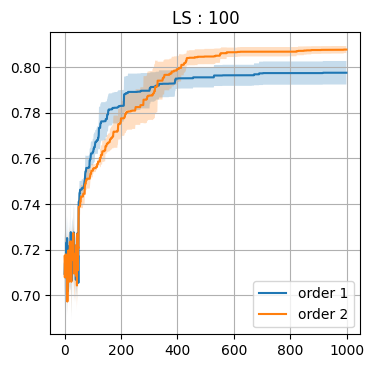

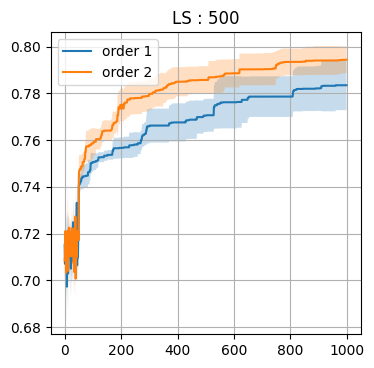

<Figure size 400x400 with 0 Axes>

In [92]:
n_LS = 100

for n_LS in [100, 500, 1000]:
    fig = plt.figure(dpi=100, figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_title(f'LS : {n_LS}')

    for k in sorted(data_results.keys()):
        ls_iter, order = k

        if ls_iter == n_LS:
            
            data = np.array(data_results[k])

            means = data.mean(axis=0)
            confidences = (1.9 * data.std(axis=0)) / np.sqrt(N_RUNS)
            print(confidences.shape)
            ax.plot(means, label=f'order {order}')
            ax.fill_between(np.arange(1000), means-confidences, means+confidences, alpha=.25)

    ax.grid()
    ax.legend()
    # ax.set_yscale('log')
    fig.savefig(os.path.join(output_images_folder, f'out_performance_LS-{n_LS}.pdf'), format='pdf', bbox_inches='tight')
    #plt.show()
fig.clf()